In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  # 用于处理类别不平衡

In [50]:
# 1. 数据加载与初步探索
data = pd.read_csv('d:\OneDrive\桌面\churn_train.csv')  # 数据文件名

In [51]:
# 查看数据前5行
print(data.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0       9255    15601116      P'an          686    France    Male   32   
1       1562    15766374      Leak          632   Germany    Male   42   
2       1671    15716994     Green          559     Spain    Male   24   
3       6088    15730759  Chukwudi          561    France  Female   27   
4       6670    15797900  Chinomso          517    France    Male   56   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       6       0.00              2          1               1   
1       4  119624.60              2          1               1   
2       3  114739.92              1          1               0   
3       9  135637.00              1          1               0   
4       9  142147.32              1          0               0   

   EstimatedSalary  Exited  
0        179093.26       0  
1        195978.86       0  
2         85891.02       1  
3        153080.40       1  
4         394

In [52]:
# 查看数据基本信息
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        8000 non-null   int64  
 1   CustomerId       8000 non-null   int64  
 2   Surname          8000 non-null   object 
 3   CreditScore      8000 non-null   int64  
 4   Geography        8000 non-null   object 
 5   Gender           8000 non-null   object 
 6   Age              8000 non-null   int64  
 7   Tenure           8000 non-null   int64  
 8   Balance          8000 non-null   float64
 9   NumOfProducts    8000 non-null   int64  
 10  HasCrCard        8000 non-null   int64  
 11  IsActiveMember   8000 non-null   int64  
 12  EstimatedSalary  8000 non-null   float64
 13  Exited           8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 875.1+ KB
None


In [53]:
# 查看目标变量分布（检查类别不平衡）
print(data['Exited'].value_counts())

Exited
0    6356
1    1644
Name: count, dtype: int64


In [54]:
# 2. 数据预处理
# 删除无关特征
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [55]:
# 处理缺失值（如果有）
if data.isnull().sum().sum() > 0:
    data = data.dropna()  # 或使用填充策略 data.fillna(...)

In [56]:
# 定义数值和分类特征
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [57]:
# 创建预处理管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [58]:
# 分割特征和目标变量
X = data.drop('Exited', axis=1)
y = data['Exited']

In [59]:
# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


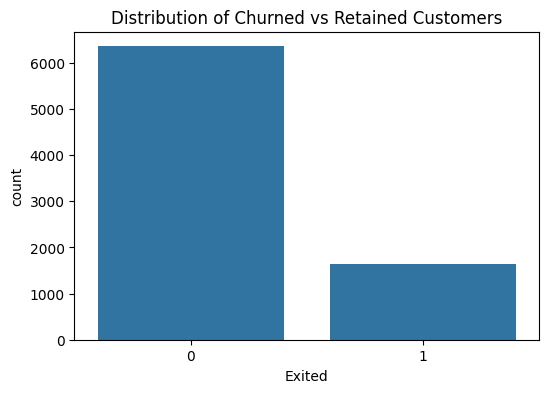

In [60]:
# 3. 探索性数据分析(EDA)
# 绘制目标变量分布
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=data)
plt.title('Distribution of Churned vs Retained Customers')
plt.show()

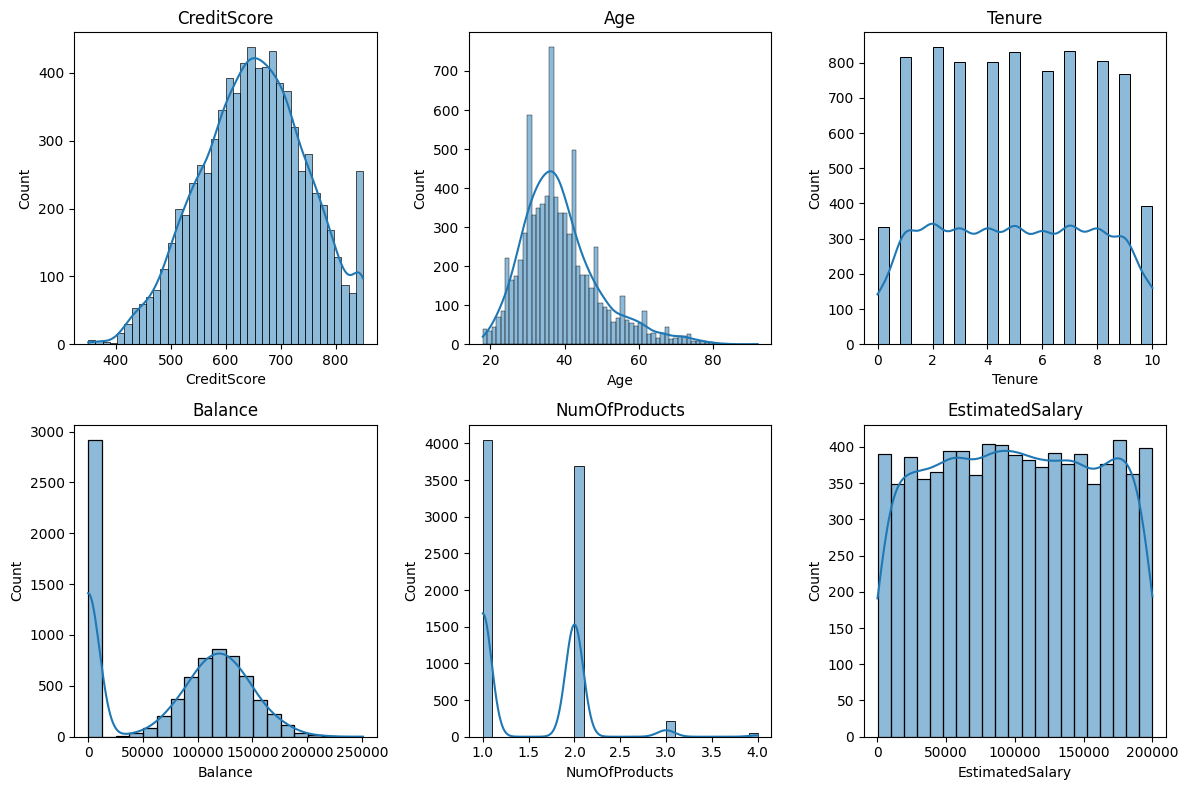

In [61]:
# 数值特征分布
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

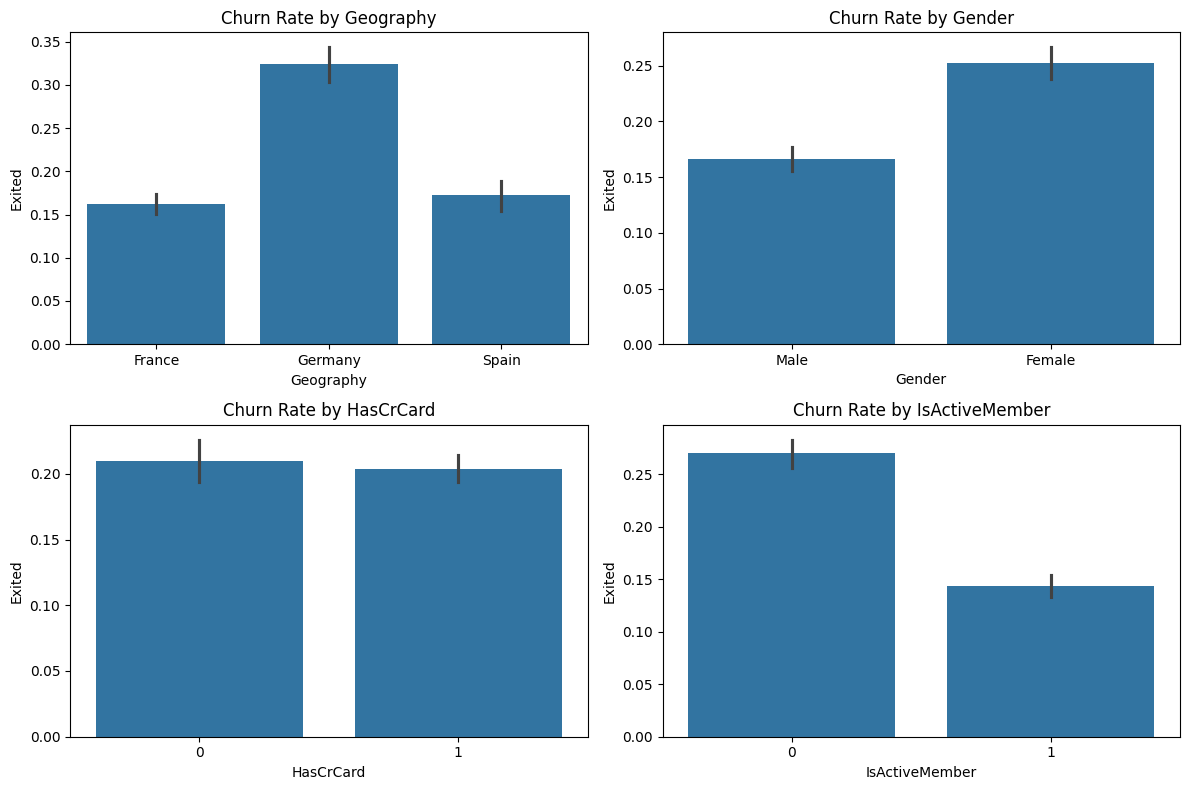

In [62]:
# 分类特征与流失率的关系
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_features):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=col, y='Exited', data=data)
    plt.title(f'Churn Rate by {col}')
plt.tight_layout()
plt.show()

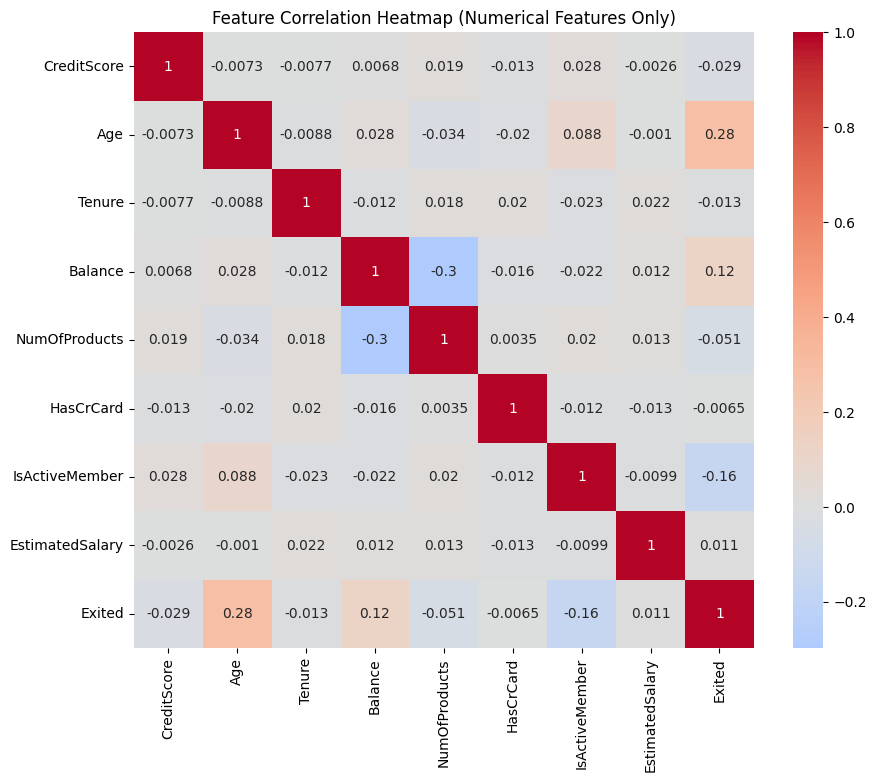

In [63]:
# 特征相关性热力图
# 选择数值列
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# 计算相关性并绘制热力图
plt.figure(figsize=(10, 8))
corr = numeric_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap (Numerical Features Only)')
plt.show()

In [64]:
# 4. 模型训练与评估
# 定义评估函数
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC曲线
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()


In [65]:
# 定义特征类型
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']  # 根据实际数据调整

# 创建预处理转换器（数值列标准化，分类列独热编码）
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 对训练集预处理后再应用SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

# 测试集预处理（不应用SMOTE）
X_test_processed = preprocessor.transform(X_test)

In [66]:
# 创建模型管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

models = {
    'Logistic Regression':
    Pipeline([('preprocessor', preprocessor),
              ('classifier', LogisticRegression(random_state=42))]),
    'Random Forest':
    Pipeline([('preprocessor', preprocessor),
              ('classifier', RandomForestClassifier(random_state=42))]),
    'XGBoost':
    Pipeline([('preprocessor', preprocessor),
              ('classifier',
               XGBClassifier(random_state=42, eval_metric='logloss'))])
}


=== Logistic Regression ===
Accuracy: 0.8075
Precision: 0.5854
Recall: 0.2188
F1 Score: 0.3186
ROC AUC: 0.7673


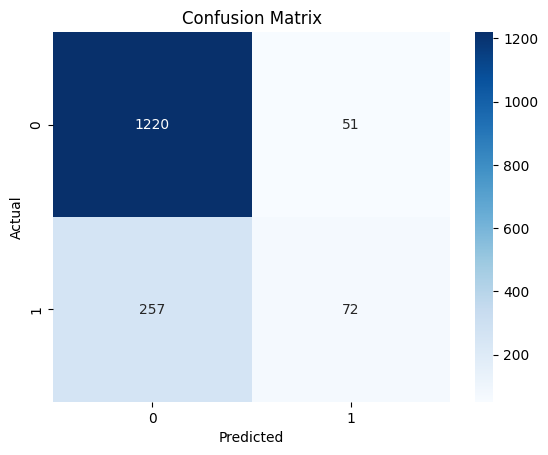

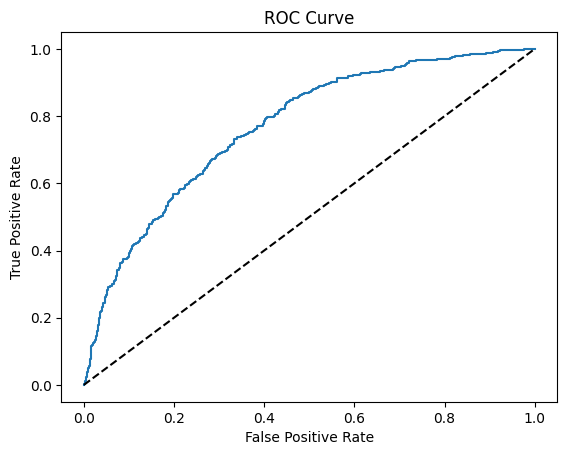


=== Random Forest ===
Accuracy: 0.8600
Precision: 0.7749
Recall: 0.4498
F1 Score: 0.5692
ROC AUC: 0.8503


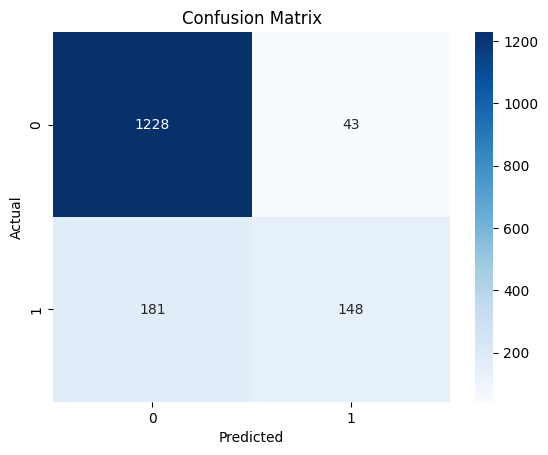

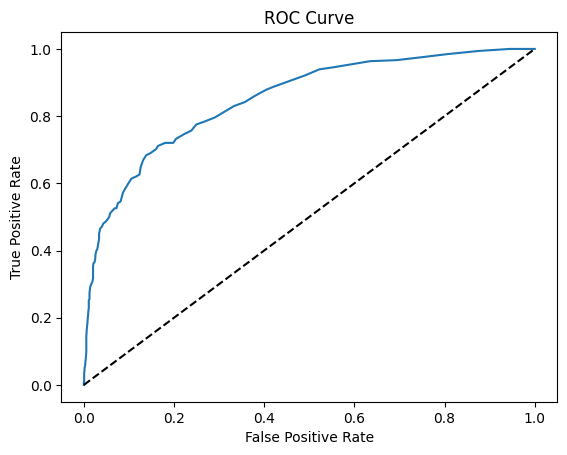


=== XGBoost ===
Accuracy: 0.8481
Precision: 0.6886
Recall: 0.4772
F1 Score: 0.5637
ROC AUC: 0.8451


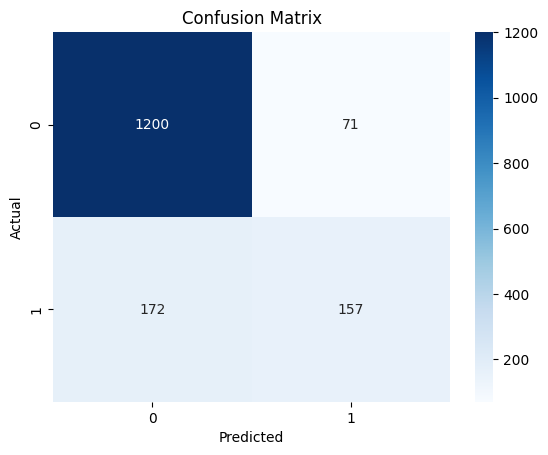

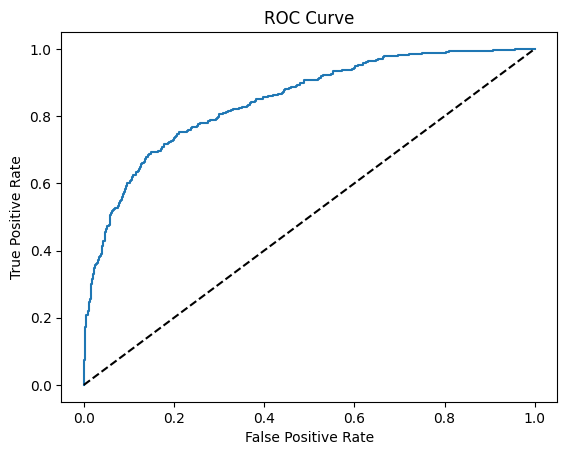

In [ ]:
#4.4 训练和评估
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)  # 输入原始数据
    evaluate_model(model, X_test, y_test)  # Pipeline会自动预处理测试数据

In [68]:
# 5. 模型优化（以XGBoost为例）
# 定义完整的 Pipeline（包含预处理、SMOTE、模型）
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # SMOTE 在 Pipeline 内部
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# 参数网格
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

# 网格搜索
grid_search = GridSearchCV(
    xgb_pipe, 
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)

# 直接传入原始数据（未处理的 X_train）
grid_search.fit(X_train, y_train)  # 不是 X_train_res

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best ROC AUC: {grid_search.best_score_:.4f}")

Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best ROC AUC: 0.8547


Accuracy: 0.8494
Precision: 0.6486
Recall: 0.5836
F1 Score: 0.6144
ROC AUC: 0.8738


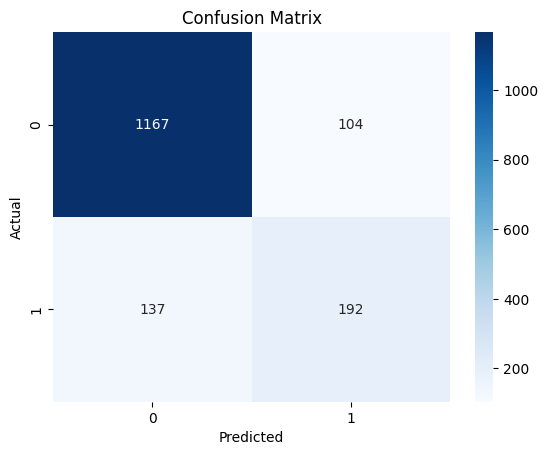

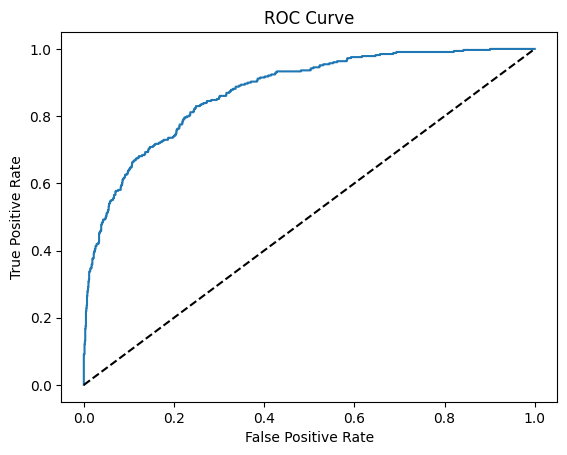

In [69]:
# 使用最佳模型进行预测
best_model = grid_search.best_estimator_
evaluate_model(best_model, X_test, y_test)

In [70]:
# 6. 特征重要性分析（以优化后的XGBoost为例）
# 获取特征名称
numeric_features_transformed = numeric_features  # 标准化后的数值特征名称不变
categorical_features_transformed = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = list(numeric_features_transformed) + list(categorical_features_transformed)

In [71]:
# 获取特征重要性
importances = best_model.named_steps['classifier'].feature_importances_
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

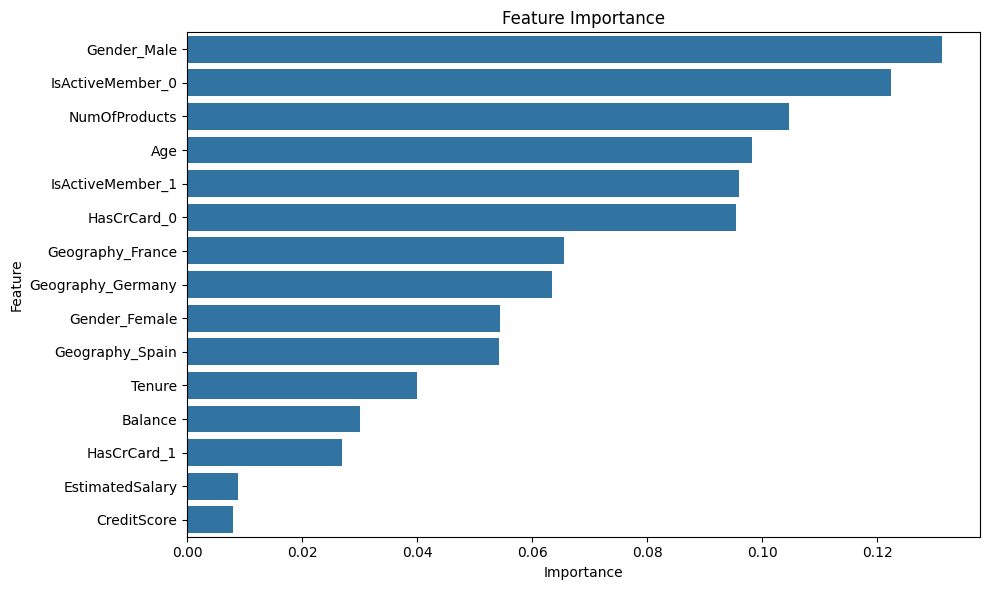

In [72]:
# 绘制特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [73]:
# 7. 业务建议
top_features = feature_importance.head(5)['Feature'].tolist()
print("\n基于分析结果，建议银行重点关注以下客户特征来降低流失率:")
for feature in top_features:
    print(f"- {feature}")


基于分析结果，建议银行重点关注以下客户特征来降低流失率:
- Gender_Male
- IsActiveMember_0
- NumOfProducts
- Age
- IsActiveMember_1
